In [3]:
import pandas as pd
import numpy as np

In [4]:
# Read the txt file into a DataFrame
df = pd.read_csv('node_embeddings.txt', sep=' ', header=None)
# Assign column names
df.columns = ['node'] + [f'feature_{i}' for i in range(1, df.shape[1])]

print("DataFrame shape:", df.shape)
print(df.head())

DataFrame shape: (3425, 257)
  node  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  ATL   0.260309   0.015411   0.016536   0.167619  -0.005803  -0.124396   
1  AMS   0.010255  -0.070210   0.161363  -0.082224  -0.118606  -0.033926   
2  FRA  -0.297854  -0.155844   0.097742   0.008270  -0.085717  -0.191249   
3  CDG  -0.120111  -0.227887   0.171155  -0.043371   0.012076  -0.070447   
4  IST   0.037998  -0.036269   0.145025  -0.016777  -0.067409  -0.097800   

   feature_7  feature_8  feature_9  ...  feature_247  feature_248  \
0   0.134288   0.322402   0.060420  ...     0.093104     0.051556   
1  -0.036534   0.140268   0.080194  ...    -0.012418     0.108368   
2  -0.113882   0.021072   0.126369  ...     0.087591     0.238929   
3  -0.090321  -0.155333   0.184417  ...     0.209709     0.283476   
4   0.131711   0.006572   0.234992  ...     0.175337     0.195883   

   feature_249  feature_250  feature_251  feature_252  feature_253  \
0     0.195558     0.103283  

Reduce Dims

UMAP shape: (3425, 2)


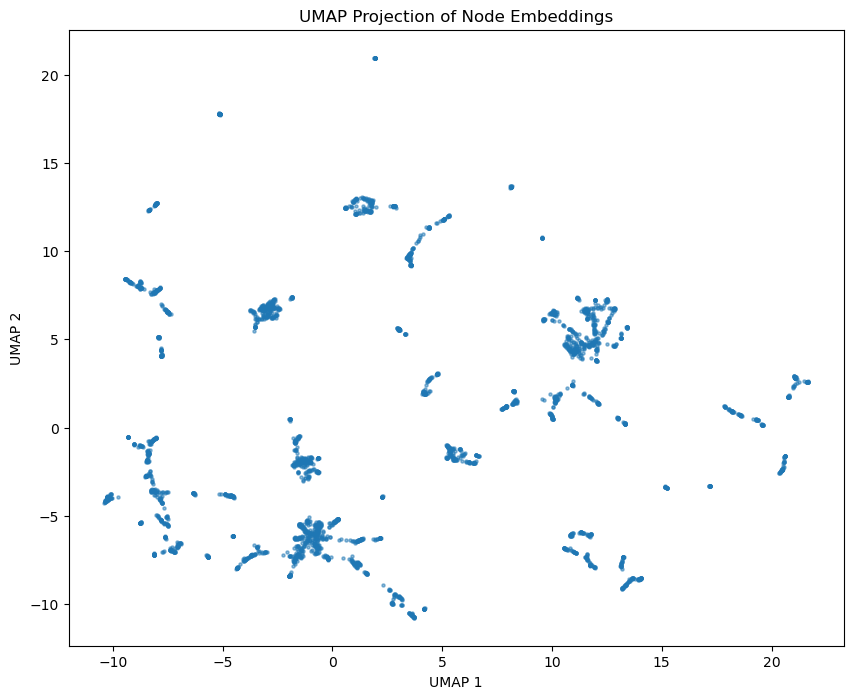

In [5]:
import umap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import hdbscan
import seaborn as sns

embedding_reduced = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine').fit_transform(df.iloc[:, 1:].values)
print("UMAP shape:", embedding_reduced.shape)
# Create a DataFrame for the UMAP results
umap_df = pd.DataFrame(embedding_reduced, columns=['x', 'y'])
# Add the node labels to the UMAP DataFrame
umap_df['node'] = df['node']

# Print reduced embeddings

plt.figure(figsize=(10, 8))
plt.scatter(umap_df['x'], umap_df['y'], s=5, alpha=0.5)
plt.title('UMAP Projection of Node Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of clusters found: 69


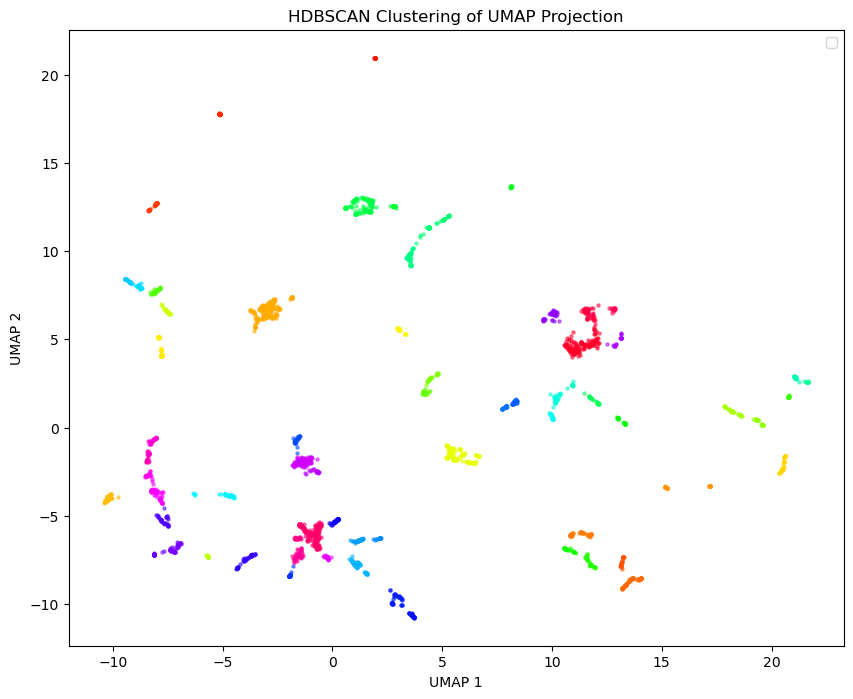

In [6]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')
# Fit the HDBSCAN model
clusterer.fit(embedding_reduced)
# Get the cluster labels
labels = clusterer.labels_
# Add the cluster labels to the UMAP DataFrame
umap_df['cluster'] = labels
# Print the number of clusters found
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Number of clusters found: {num_clusters}')
# Plot the clusters
plt.figure(figsize=(10, 8))
# Create a color palette
palette = sns.color_palette("hsv", num_clusters)
# Create a scatter plot with colors based on cluster labels
for i in range(num_clusters):
    cluster_data = umap_df[umap_df['cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'], s=5, alpha=0.5, color=palette[i])
plt.title('HDBSCAN Clustering of UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

Extract Embedding

In [7]:
import random

labels = clusterer.labels_ # Shape (N,) - Cluster assignment for each point
# embedding = embedding      # Your 2D UMAP data, shape (N, 2)
# --------------------------------

# 1. Get unique cluster IDs, excluding noise (-1)
unique_labels = np.unique(labels)
valid_cluster_ids = unique_labels[unique_labels != -1]

# 2. Check if any valid clusters exist
if len(valid_cluster_ids) == 0:
    print("No valid clusters found (all points might be noise).")
else:
    # 3. Choose a random cluster ID from the valid ones
    target_cluster_id = random.choice(valid_cluster_ids)
    print(f"Randomly selected cluster ID: {target_cluster_id}")

    # 4. Create a boolean mask for the selected cluster
    cluster_mask = (labels == target_cluster_id)

    # 5. Apply the mask to extract the embeddings for that cluster
    embeddings_in_cluster = embedding_reduced[cluster_mask]

    print(f"Number of points in cluster {target_cluster_id}: {len(embeddings_in_cluster)}")

    # You can now work with 'embeddings_in_cluster'
    # For example, print the first 5 embeddings in this cluster:
    if len(embeddings_in_cluster) > 0:
        print("First 5 embeddings in this cluster:")
        print(embeddings_in_cluster[:5])
    else:
         # This shouldn't happen if the ID was in valid_cluster_ids, but good practice
         print(f"Cluster {target_cluster_id} reported as valid, but no points found (check data consistency).")


Randomly selected cluster ID: 23
Number of points in cluster 23: 30
First 5 embeddings in this cluster:
[[13.290135    0.262799  ]
 [12.972203    0.5604049 ]
 [12.96203     0.56992745]
 [13.2828245   0.2689662 ]
 [13.344982    0.21014087]]


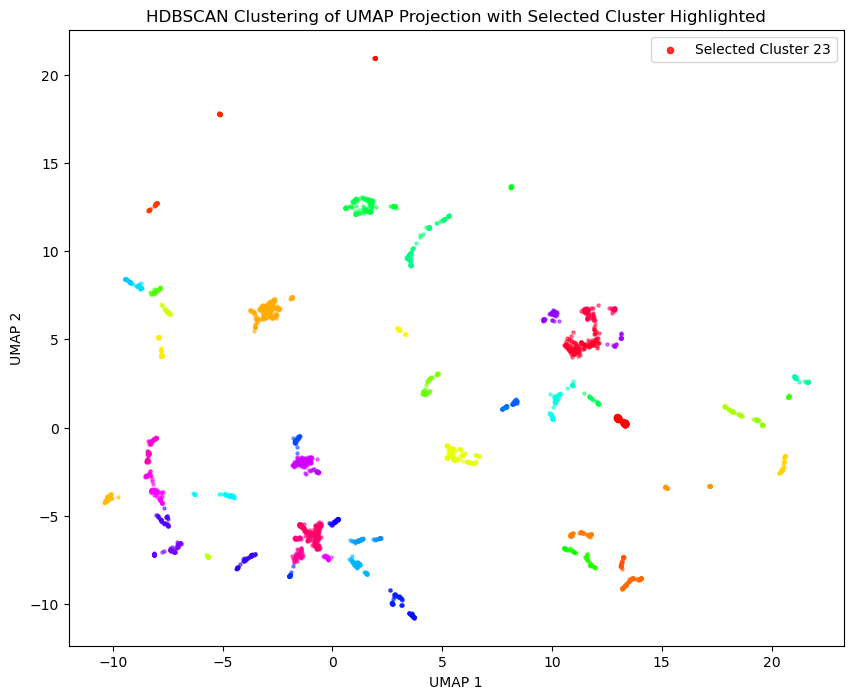

In [8]:
# Visualize the selected cluster
plt.figure(figsize=(10, 8))
# Create a color palette
palette = sns.color_palette("hsv", num_clusters)
# Create a scatter plot with colors based on cluster labels
for i in range(num_clusters):
    cluster_data = umap_df[umap_df['cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'], s=5, alpha=0.5, color=palette[i])
# Highlight the selected cluster
selected_cluster_data = umap_df[umap_df['cluster'] == target_cluster_id]
plt.scatter(selected_cluster_data['x'], selected_cluster_data['y'], s=20, alpha=0.8, color='red', label=f'Selected Cluster {target_cluster_id}')
plt.title('HDBSCAN Clustering of UMAP Projection with Selected Cluster Highlighted')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

Get Airport Info

In [9]:
for emb in embeddings_in_cluster:
    index = np.where((embedding_reduced == emb).all(axis=1))[0][0]
    node = umap_df.iloc[index]['node']

    print(f"Node: {node}, Embedding: {emb}")

Node: PAC, Embedding: [13.290135  0.262799]
Node: SJO, Embedding: [12.972203   0.5604049]
Node: LIR, Embedding: [12.96203     0.56992745]
Node: BOC, Embedding: [13.2828245  0.2689662]
Node: PVE, Embedding: [13.344982    0.21014087]
Node: PYC, Embedding: [13.318711    0.23547517]
Node: OGM, Embedding: [13.333007    0.22189556]
Node: MPP, Embedding: [13.346812    0.20866548]
Node: ACU, Embedding: [13.310111    0.24445574]
Node: SIC, Embedding: [13.325252    0.22897108]
Node: OTD, Embedding: [13.33944     0.21552192]
Node: JQE, Embedding: [13.327734    0.22677226]
Node: BFQ, Embedding: [13.337958    0.21708588]
Node: GHE, Embedding: [13.302979    0.25103998]
Node: SAX, Embedding: [13.337067    0.21735926]
Node: CHX, Embedding: [13.309963    0.24284932]
Node: DAV, Embedding: [13.240652    0.30868417]
Node: XQP, Embedding: [13.009539   0.5259946]
Node: CZJ, Embedding: [13.333228    0.22159864]
Node: PUE, Embedding: [13.334185    0.22039765]
Node: TMU, Embedding: [13.025131   0.5104557]
Node

In [10]:
# Get frequency of each destination node in the selected cluster

routes = pd.read_csv('routes.csv')
# Get elements from Destination airport where Sourcer airport is an element of the selected cluster
selected_nodes = umap_df[umap_df['cluster'] == target_cluster_id]['node'].unique()
# Filter the routes DataFrame to include only rows where the source airport is in the selected cluster
filtered_routes = routes[routes['Source airport'].isin(selected_nodes)]
# Get the unique destination airports from the filtered DataFrame
unique_destinations = filtered_routes['Destination airport'].unique()
destination_counts = filtered_routes['Destination airport'].value_counts()

destination_df = pd.DataFrame(destination_counts).reset_index()
destination_df.columns = ['Destination airport', 'Frequency']
# Sort the DataFrame by frequency in descending order
destination_df = destination_df.sort_values(by='Frequency', ascending=False)

print("Top 10 destination airports from the selected cluster:")
print(destination_df.head(10))

Top 10 destination airports from the selected cluster:
   Destination airport  Frequency
0                  SJO         28
1                  PAC          8
2                  XQP          5
3                  JFK          5
4                  PTY          5
5                  MIA          5
6                  CLT          5
11                 ATL          4
14                 PJM          4
12                 TMU          4


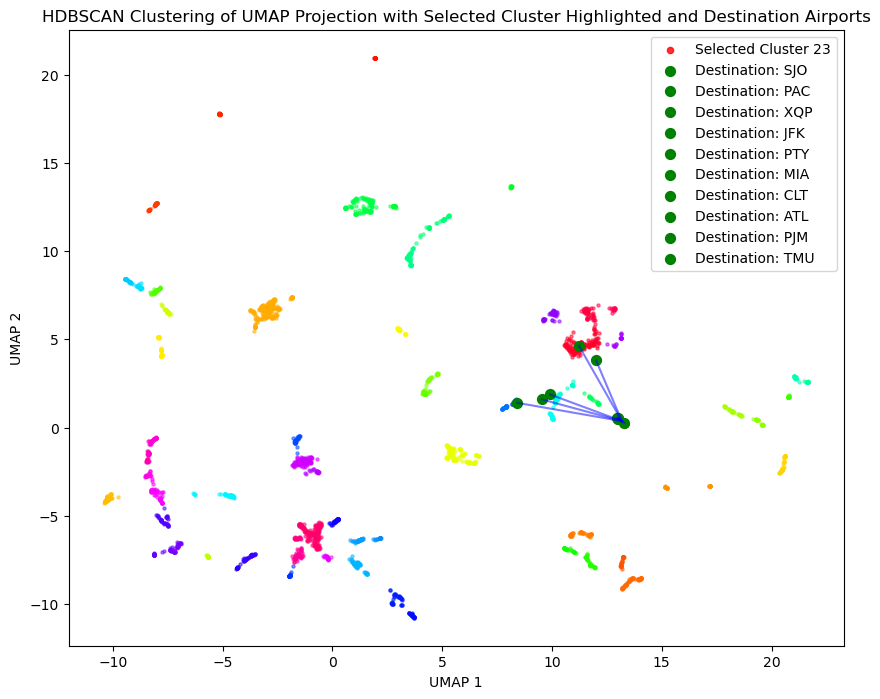

In [11]:
# Get destination airports and plot the UMAP projection with lines drawing to the destination airports
# Create a DataFrame for the destination airports
destination_df = pd.DataFrame(destination_counts).reset_index()
destination_df.columns = ['Destination airport', 'Frequency']
# Sort the DataFrame by frequency in descending order
destination_df = destination_df.sort_values(by='Frequency', ascending=False)
# Get the top 10 destination airports
top_10_destinations = destination_df.head(10)
# Create a scatter plot of the UMAP projection
plt.figure(figsize=(10, 8))
# Create a color palette
palette = sns.color_palette("hsv", num_clusters)
# Create a scatter plot with colors based on cluster labels
for i in range(num_clusters):
    cluster_data = umap_df[umap_df['cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'], s=5, alpha=0.5, color=palette[i])
# Highlight the selected cluster
selected_cluster_data = umap_df[umap_df['cluster'] == target_cluster_id]
plt.scatter(selected_cluster_data['x'], selected_cluster_data['y'], s=20, alpha=0.8, color='red', label=f'Selected Cluster {target_cluster_id}')
# Draw lines to the top 10 destination airports
for index, row in top_10_destinations.iterrows():
    destination_node = row['Destination airport']
    # Get the coordinates of the destination node
    destination_coords = umap_df[umap_df['node'] == destination_node][['x', 'y']]
    if not destination_coords.empty:
        plt.plot([selected_cluster_data['x'].mean(), destination_coords['x'].values[0]], 
                 [selected_cluster_data['y'].mean(), destination_coords['y'].values[0]], 
                 color='blue', alpha=0.5)
        plt.scatter(destination_coords['x'], destination_coords['y'], s=50, color='green', label=f'Destination: {destination_node}')
plt.title('HDBSCAN Clustering of UMAP Projection with Selected Cluster Highlighted and Destination Airports')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

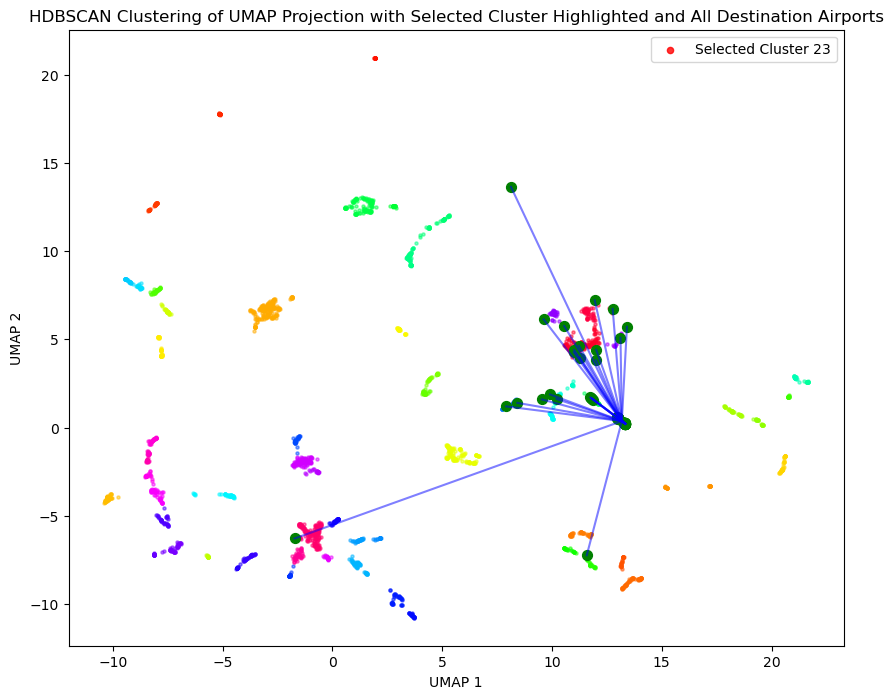

In [13]:
# Plot UMAP projection with lines drawing to every destination airport
plt.figure(figsize=(10, 8))
# Create a color palette
palette = sns.color_palette("hsv", num_clusters)
# Create a scatter plot with colors based on cluster labels
for i in range(num_clusters):
    cluster_data = umap_df[umap_df['cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'], s=5, alpha=0.5, color=palette[i])
# Highlight the selected cluster
selected_cluster_data = umap_df[umap_df['cluster'] == target_cluster_id]
plt.scatter(selected_cluster_data['x'], selected_cluster_data['y'], s=20, alpha=0.8, color='red', label=f'Selected Cluster {target_cluster_id}')
# Draw lines to every destination airport
for index, row in destination_df.iterrows():
    destination_node = row['Destination airport']
    # Get the coordinates of the destination node
    destination_coords = umap_df[umap_df['node'] == destination_node][['x', 'y']]
    if not destination_coords.empty:
        plt.plot([selected_cluster_data['x'].mean(), destination_coords['x'].values[0]], 
                 [selected_cluster_data['y'].mean(), destination_coords['y'].values[0]], 
                 color='blue', alpha=0.5)
        plt.scatter(destination_coords['x'], destination_coords['y'], s=50, color='green')
plt.title('HDBSCAN Clustering of UMAP Projection with Selected Cluster Highlighted and All Destination Airports')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

In [21]:
# Get destination airport for every node

routes = pd.read_csv('routes.csv')
# Get elements
selected_nodes = umap_df['node'].unique()
# Filter the routes DataFrame to include only rows where the source airport is in the selected cluster
filtered_routes = routes[routes['Source airport'].isin(selected_nodes)]
# Get the unique destination airports from the filtered DataFrame
unique_destinations = filtered_routes['Destination airport'].unique()
destination_counts = filtered_routes['Destination airport'].value_counts()

destination_df = pd.DataFrame(destination_counts).reset_index()
destination_df.columns = ['Destination airport', 'Frequency']
# Sort the DataFrame by frequency in descending order
destination_df = destination_df.sort_values(by='Frequency', ascending=False)

print("Top 10 destination airports from the selected cluster:")
print(destination_df.head(10))

Top 10 destination airports from the selected cluster:
  Destination airport  Frequency
0                 ATL        911
1                 ORD        550
2                 PEK        534
3                 LHR        524
4                 CDG        517
5                 LAX        498
6                 FRA        493
7                 DFW        467
8                 JFK        455
9                 AMS        450


In [23]:
# Plot every destination airport
plt.figure(figsize=(10, 8))
# Create a color palette
palette = sns.color_palette("hsv", num_clusters)
# Create a scatter plot with colors based on cluster labels
for i in range(num_clusters):
    cluster_data = umap_df[umap_df['cluster'] == i]
    plt.scatter(cluster_data['x'], cluster_data['y'], s=5, alpha=0.5, color=palette[i])
# Draw lines between source and destination airports
for index, row in routes.iterrows():
    source_node = row['Source airport']
    destination_node = row['Destination airport']
    # Get the coordinates of the source and destination nodes
    source_coords = umap_df[umap_df['node'] == source_node][['x', 'y']]
    destination_coords = umap_df[umap_df['node'] == destination_node][['x', 'y']]
    if not source_coords.empty and not destination_coords.empty:
        plt.plot([source_coords['x'].values[0], destination_coords['x'].values[0]], 
                 [source_coords['y'].values[0], destination_coords['y'].values[0]], 
                 color='blue', alpha=0.5)
        plt.scatter(destination_coords['x'], destination_coords['y'], s=50, color='green')
plt.title('HDBSCAN Clustering of UMAP Projection with Selected Cluster Highlighted and Top 10 Destination Airports')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001C3845D4040> (for post_execute):


KeyboardInterrupt: 

: 